In [1]:
import os

In [2]:
import andi
import joblib
import pickle
import sklearn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dalex as dx

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split

pd.options.plotting.backend = 'plotly'
import plotly
import plotly.express as px

from configuration import RANDOM_STATE, CLASS_MAPPING

In [3]:
RANDOM_STATE = 42

In [4]:
def custom_residual_function(model, X, y):
    probs = model.predict_proba(X)
    real_class_pred = probs.flatten()[[int(probs.shape[1]*i+val) for i, val in enumerate(y)]]
    return np.abs((1 - real_class_pred).astype('float64'))

def custom_predict(model, X):
    return model.predict_proba(X)

def custom_predict_normal(model, X):
    return model.predict(X)

def custom_predict_old(model, X):
    pred_class = np.argmax(model.predict_proba(X), axis=1)
    return pred_class.astype('float')

def loss_accuracy(y_real, y_pred):
    return 1 - accuracy_score(y_real, y_pred)

def loss_multiclass(y_real, y_proba):
    proba_real = np.array([el[y_real[i]] for i, el in enumerate(y_proba)])
    return np.mean(1 - proba_real)

def categorical_cross_entropy(y_real, y_proba):        
    return np.mean(-np.log(y_proba.flatten()[[int(y_proba.shape[1]*i+value) for i,value in enumerate(y_real)]]))



In [5]:
def save_image(image, image_path):
    image.write_image(image_path)

In [6]:
sklearn.__version__

'0.24.1'

In [7]:
model = joblib.load('Models/model_patrycja_2d.sav')
# model_hanna = joblib.load('Models/model_hanna_2d.sav')

In [8]:
model.n_features_

17

In [9]:
X = pd.read_csv('Data/characteristics/characteristics_2D.csv')
X = X.drop(['index', 'file', 'diff_type'], axis=1)
y, X = X['motion'], X.drop(['motion'], axis=1)

In [10]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=1/6, random_state=RANDOM_STATE)

In [11]:
feature_names = X.columns

## Plan:
1. Overall model performance, standard feature importance -- done
2. Permutation feature importance --> eli5, dalex -- done
3. SHAP feature importance;
4. Stratx;
5. Partial dependence profiles;

## 1. Overall model performance

In [12]:
y_pred = model.predict(x_test)
y_proba = model.predict_proba(x_test)

In [13]:
generated_data_hist = px.histogram(y)

In [18]:
save_image(generated_data_hist, os.path.join('Explanation', 'generated_data_hist.png'))

In [19]:
predicted_data_hist = px.histogram(y_pred)

In [20]:
save_image(predicted_data_hist, os.path.join('Explanation', 'predicted_data_hist.png'))

In [21]:
confusion_matrix(y_test, y_pred)

array([[ 775,  480,   79,   19,  639],
       [ 279, 1667,   54,    0,   40],
       [  71,   43, 1241,  182,  491],
       [  19,    1,  127, 1721,  114],
       [ 343,   41,  188,   25, 1361]])

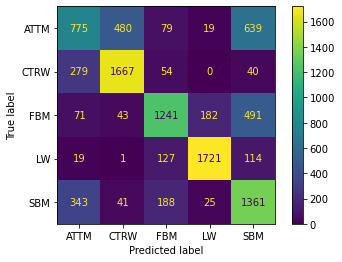

In [22]:
confusion_matrix_ = plot_confusion_matrix(model, x_test, y_test, display_labels=CLASS_MAPPING.values())

In [26]:
confusion_matrix_.figure_.savefig(os.path.join('Explanation', 'confusion_matrix.png'))
confusion_matrix_.figure_.savefig(os.path.join('Explanation', 'confusion_matrix.pdf'))

In [35]:
COMMON_ERRORS = {'ATTM': 'SBM', 'FBM': 'SBM', 'ATTM': 'CTRW', 'SBM': 'ATTM'}

In [41]:
# Most common errors
pd.DataFrame(zip(COMMON_ERRORS.keys(), COMMON_ERRORS.values()), columns=['True', 'Predicted'])

,True,Predicted
0,ATTM,CTRW
1,FBM,SBM
2,SBM,ATTM


In [22]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.52      0.39      0.45      1992
         1.0       0.75      0.82      0.78      2040
         2.0       0.73      0.61      0.67      2028
         3.0       0.88      0.87      0.88      1982
         4.0       0.51      0.70      0.59      1958

    accuracy                           0.68     10000
   macro avg       0.68      0.68      0.67     10000
weighted avg       0.68      0.68      0.67     10000



## 2. Permutation feature importance with eli5

In [27]:
import eli5
from eli5.sklearn import PermutationImportance

In [29]:
model.feature_importances_

array([0.03578729, 0.04528068, 0.03467109, 0.03431023, 0.03654937,
       0.04106779, 0.03066496, 0.16729902, 0.07560637, 0.0329682 ,
       0.01166914, 0.05670549, 0.08795822, 0.08365619, 0.05915253,
       0.10243833, 0.06421512])

In [31]:
standard_fi_plot = px.bar(y=feature_names, x=model.feature_importances_)

In [33]:
save_image(standard_fi_plot, os.path.join('Explanation', 'standard_fi.png'))

### Basic permutation feature importance with eli5

In [34]:
perm = PermutationImportance(model).fit(x_test, y_test)

In [36]:
permutation_fi = eli5.show_weights(perm, feature_names=list(feature_names))

In [47]:
with open(os.path.join('Explanation','eli5-pfi.html'), 'w') as f:
    f.write(permutation_fi.data)


### Dalex explainer

In [48]:
explainer_proba = dx.Explainer(model, x_test, y_test, predict_function=custom_predict, residual_function=custom_residual_function)
explainer_normal = dx.Explainer(model, x_test, y_test, predict_function=custom_predict_normal, residual_function=custom_residual_function)

Preparation of a new explainer is initiated

  -> data              : 10000 rows 17 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 10000 values
  -> model_class       : sklearn.ensemble._gb.GradientBoostingClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function custom_predict at 0x7f315f1644d0> will be used
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 9.18e-14, mean = 0.2, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : <function custom_residual_function at 0x7f315f1648c0>


/home/llaszczuk/anaconda3/envs/analiza_dyfuzji/lib/python3.7/site-packages/dalex/_explainer/object.py:140: UserWarning:


  -> predicted values  : 'predict_function' must return numpy.ndarray (1d)



  -> residuals         : min = 1.39e-10, mean = 0.339, max = 1.0
  -> model_info        : package sklearn

A new explainer has been created!
Preparation of a new explainer is initiated

  -> data              : 10000 rows 17 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 10000 values
  -> model_class       : sklearn.ensemble._gb.GradientBoostingClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function custom_predict_normal at 0x7f315f169830> will be used
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0, mean = 2.2, max = 4.0
  -> model type        : classification will be used (default)
  -> residual function : <function custom_residual_function at 0x7f315f1648c0>
  -> residuals         : min = 1.39e-10, mean = 0.339, max = 1.0
  -> model_info        : package sklearn

A new

In [49]:
pfi = explainer_proba.model_parts(loss_function=categorical_cross_entropy)

In [62]:
pfi_categorical_cross_entropy = pfi.plot(max_vars=17, show=False)

In [63]:
save_image(pfi_categorical_cross_entropy, os.path.join('Explanation', 'pfi-logloss.png'))

### Categorical cross entropy loss function

In [64]:
pfi_categorical_cross_entropy

In [67]:
pfi_accuracy = explainer_normal.model_parts(loss_function=loss_accuracy)
pfi_accuracy_plot = pfi_accuracy.plot(max_vars=17, show=False)

In [68]:
save_image(pfi_accuracy_plot, os.path.join('Explanation', 'pfi-accuracy.png'))

### Accuracy loss function

In [69]:
pfi_accuracy_plot

### PFI per class

In [124]:
x_test['y'] = y_test
for i in range(5):    
    x_sub = x_test[x_test['y'] == i]
    y_sub, x_sub = x_sub['y'], x_sub.drop('y', axis=1)
    print(y_sub)
    
    explainer_sub = dx.Explainer(model, x_sub, y_sub, predict_function=custom_predict, residual_function=custom_residual_function)    
    pfi = explainer_sub.model_parts(loss_function=categorical_cross_entropy)
    pfi_plot = pfi.plot(max_vars=17, show=False)
    save_image(pfi_plot, os.path.join('Explanation', 'class_pfi', f"pfi-logloss-{CLASS_MAPPING[str(i)]}.pdf"))
    
    explainer_normal = dx.Explainer(model, x_sub, y_sub, predict_function=custom_predict_normal, residual_function=custom_residual_function)
    pfi = explainer_normal.model_parts(loss_function=loss_accuracy)
    pfi_plot = pfi.plot(max_vars=17, show=False)
    save_image(pfi_plot, os.path.join('Explanation', 'class_pfi', f"pfi-acc-{CLASS_MAPPING[str(i)]}.pdf"))

15127    0.0
53390    0.0
21819    0.0
47038    0.0
26064    0.0
        ... 
330      0.0
37932    0.0
43762    0.0
56210    0.0
14474    0.0
Name: y, Length: 1992, dtype: float64
Preparation of a new explainer is initiated

  -> data              : 1992 rows 17 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 1992 values
  -> model_class       : sklearn.ensemble._gb.GradientBoostingClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function custom_predict at 0x7f315f1644d0> will be used
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 5.84e-10, mean = 0.2, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : <function custom_residual_function at 0x7f315f1648c0>



  -> predicted values  : 'predict_function' must return numpy.ndarray (1d)


  -> residuals         : min = 2.29e-06, mean = 0.601, max = 1.0
  -> model_info        : package sklearn

A new explainer has been created!
Preparation of a new explainer is initiated

  -> data              : 1992 rows 17 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 1992 values
  -> model_class       : sklearn.ensemble._gb.GradientBoostingClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function custom_predict_normal at 0x7f315f169830> will be used
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0, mean = 1.63, max = 4.0
  -> model type        : classification will be used (default)
  -> residual function : <function custom_residual_function at 0x7f315f1648c0>
  -> residuals         : min = 2.29e-06, mean = 0.601, max = 1.0
  -> model_info        : package sklearn

A new 


  -> predicted values  : 'predict_function' must return numpy.ndarray (1d)


  -> residuals         : min = 5.47e-08, mean = 0.208, max = 1.0
  -> model_info        : package sklearn

A new explainer has been created!
Preparation of a new explainer is initiated

  -> data              : 2040 rows 17 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 2040 values
  -> model_class       : sklearn.ensemble._gb.GradientBoostingClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function custom_predict_normal at 0x7f315f169830> will be used
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0, mean = 0.949, max = 4.0
  -> model type        : classification will be used (default)
  -> residual function : <function custom_residual_function at 0x7f315f1648c0>
  -> residuals         : min = 5.47e-08, mean = 0.208, max = 1.0
  -> model_info        : package sklearn

A new


  -> predicted values  : 'predict_function' must return numpy.ndarray (1d)


  -> residuals         : min = 8.11e-07, mean = 0.387, max = 1.0
  -> model_info        : package sklearn

A new explainer has been created!
Preparation of a new explainer is initiated

  -> data              : 2028 rows 17 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 2028 values
  -> model_class       : sklearn.ensemble._gb.GradientBoostingClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function custom_predict_normal at 0x7f315f169830> will be used
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0, mean = 2.48, max = 4.0
  -> model type        : classification will be used (default)
  -> residual function : <function custom_residual_function at 0x7f315f1648c0>
  -> residuals         : min = 8.11e-07, mean = 0.387, max = 1.0
  -> model_info        : package sklearn

A new 


  -> predicted values  : 'predict_function' must return numpy.ndarray (1d)


  -> residuals         : min = 1.39e-10, mean = 0.137, max = 1.0
  -> model_info        : package sklearn

A new explainer has been created!
Preparation of a new explainer is initiated

  -> data              : 1982 rows 17 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 1982 values
  -> model_class       : sklearn.ensemble._gb.GradientBoostingClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function custom_predict_normal at 0x7f315f169830> will be used
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0, mean = 2.96, max = 4.0
  -> model type        : classification will be used (default)
  -> residual function : <function custom_residual_function at 0x7f315f1648c0>
  -> residuals         : min = 1.39e-10, mean = 0.137, max = 1.0
  -> model_info        : package sklearn

A new 


  -> predicted values  : 'predict_function' must return numpy.ndarray (1d)


  -> residuals         : min = 8.9e-05, mean = 0.365, max = 1.0
  -> model_info        : package sklearn

A new explainer has been created!
Preparation of a new explainer is initiated

  -> data              : 1958 rows 17 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 1958 values
  -> model_class       : sklearn.ensemble._gb.GradientBoostingClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function custom_predict_normal at 0x7f315f169830> will be used
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0, mean = 3.03, max = 4.0
  -> model type        : classification will be used (default)
  -> residual function : <function custom_residual_function at 0x7f315f1648c0>
  -> residuals         : min = 8.9e-05, mean = 0.365, max = 1.0
  -> model_info        : package sklearn

A new ex

## 3. SHAP

In [71]:
import shap

In [84]:
EXPLAIN_OBSERVATION_NO = 1000

In [74]:
def generate_shap_values(model, x, i):
    med = x.median().values.reshape((1, x.shape[1]))
    shap_model = shap.KernelExplainer(model.predict_proba, med, )
    shap_values = shap_model.shap_values(x.iloc[:i, :], )
    return shap_model, shap_values

In [76]:
shap_values = generate_shap_values(model, x_test, EXPLAIN_OBSERVATION_NO)

In [79]:
shap_model, shap_coefs = shap_values[0], shap_values[1]

In [80]:
base_value = shap_model.expected_value

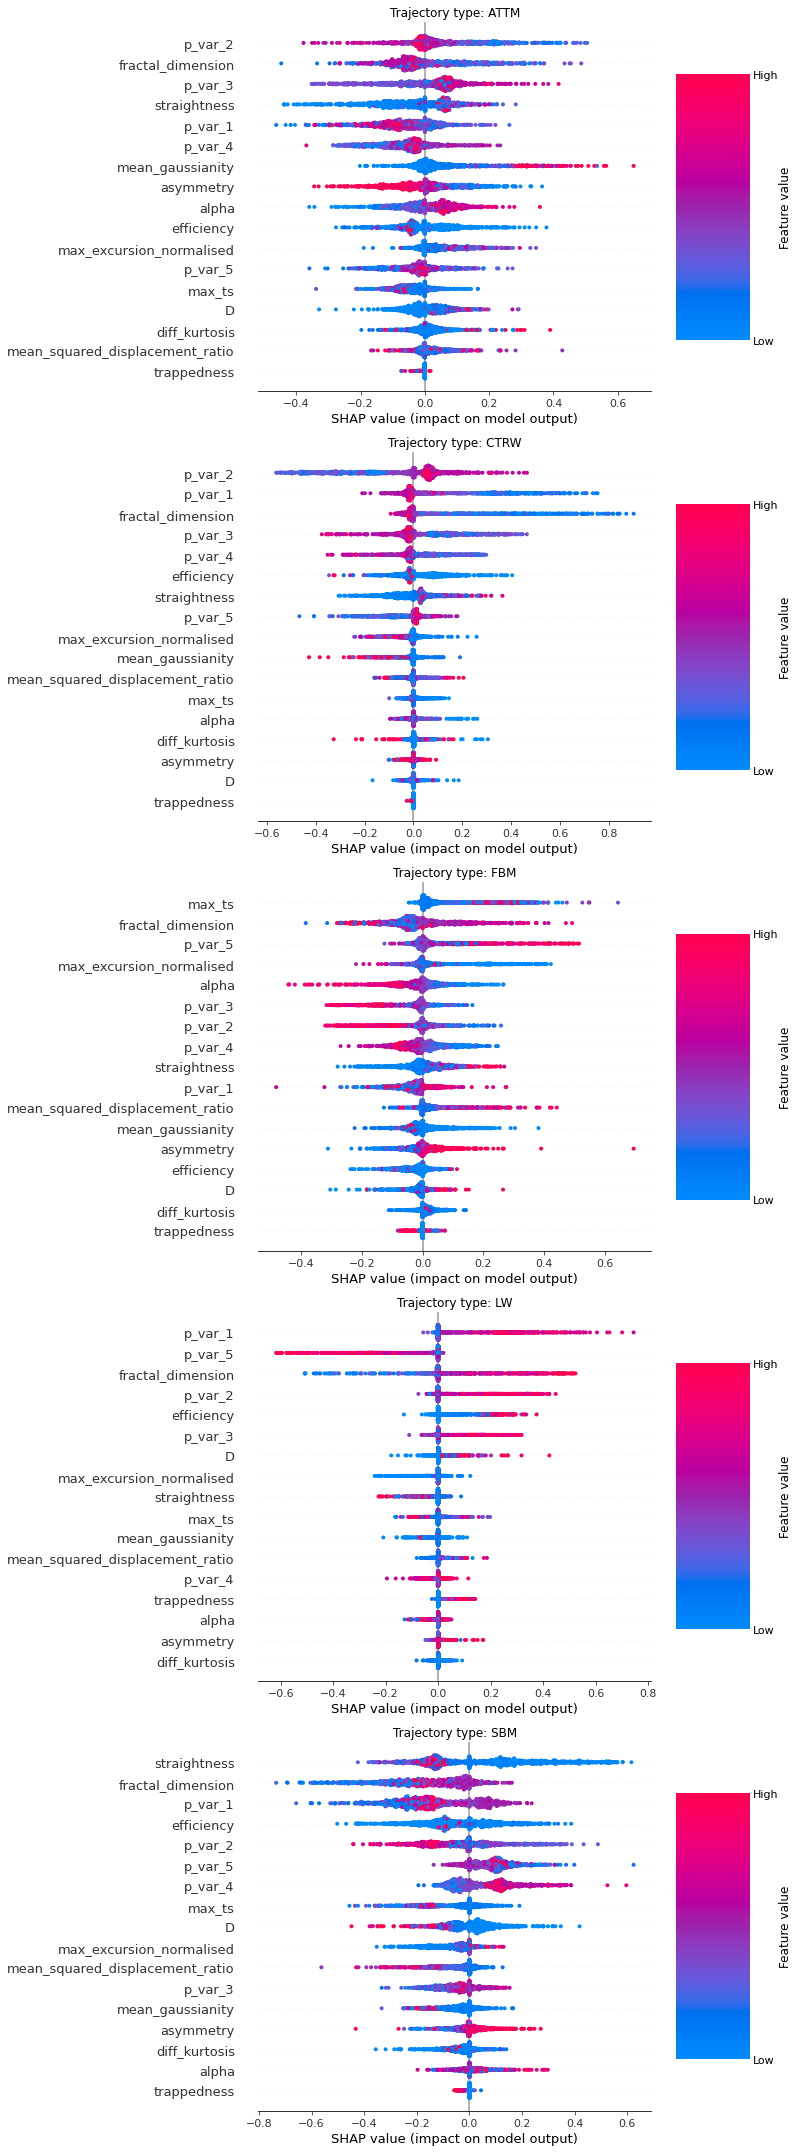

In [104]:
fig, axs = plt.subplots(5, 1)
for i in range(5):
    plt.sca(axs[i])
    shap.summary_plot(shap_coefs[i], x_test.values[:EXPLAIN_OBSERVATION_NO, :], x_test.columns, plot_type='dot', show=False)
    plt.gca().set_title(f"Trajectory type: {CLASS_MAPPING[str(int(model.classes_[i]))]}")
fig.set_size_inches(11, 30)
fig.tight_layout()
plt.savefig(os.path.join('Explanation', 'SHAP', 'SHAP-dot.pdf'), dpi=500)

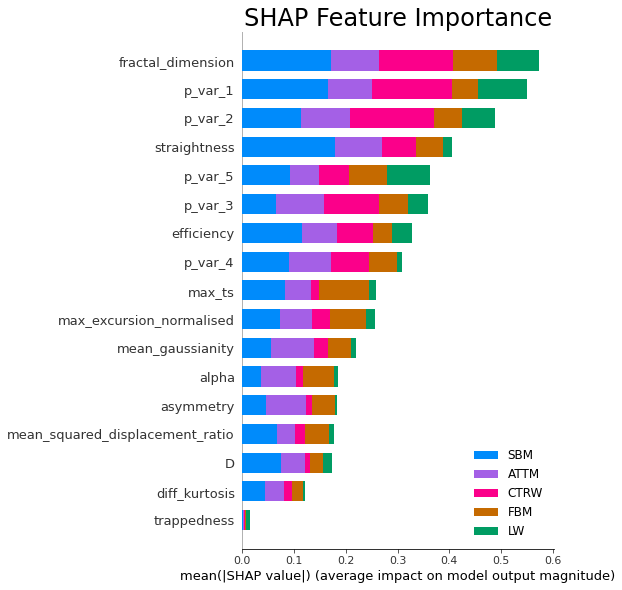

In [109]:
plt.figure()
shap.summary_plot(shap_coefs, x_test.columns, plot_type='bar', class_names=list(CLASS_MAPPING.values()), show=False)
plt.title('SHAP Feature Importance', size=24)
fig.set_size_inches(14, 8)
plt.tight_layout()
plt.savefig(os.path.join('Explanation', 'SHAP', 'SHAP-FI-all.pdf'), dpi=500)
plt.show()

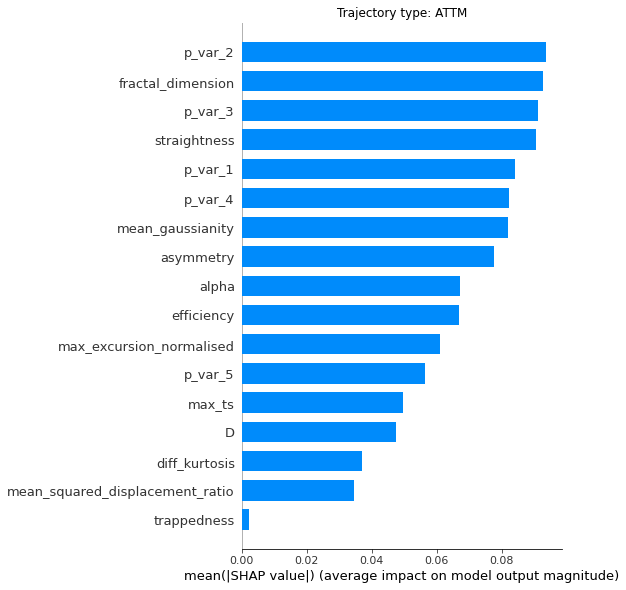

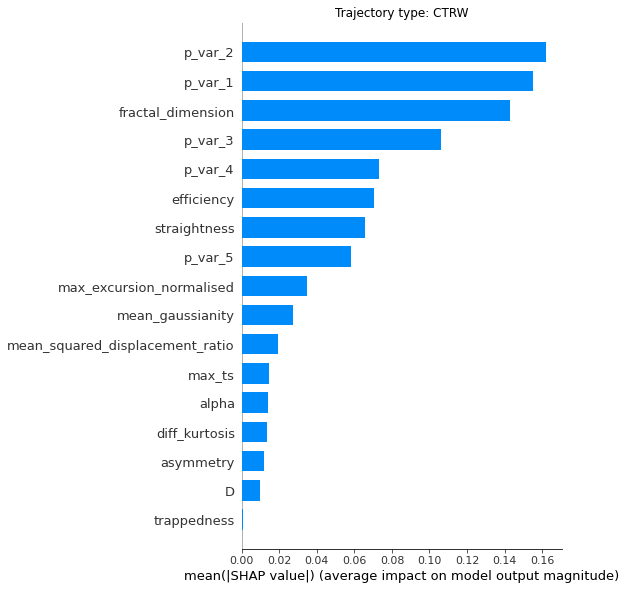

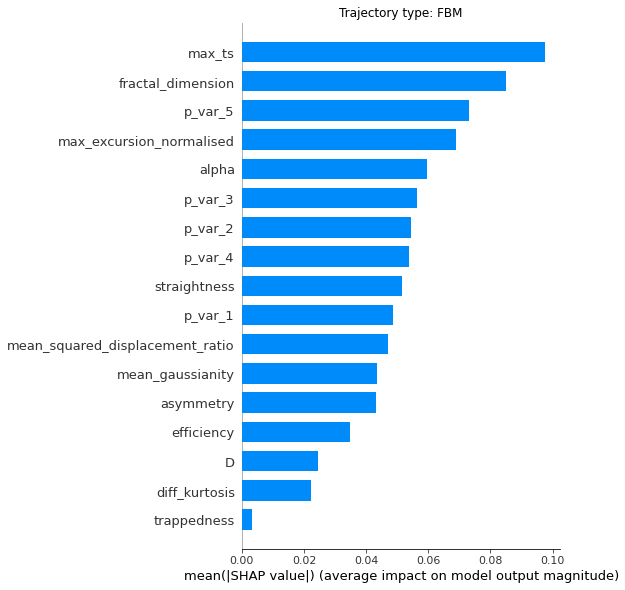

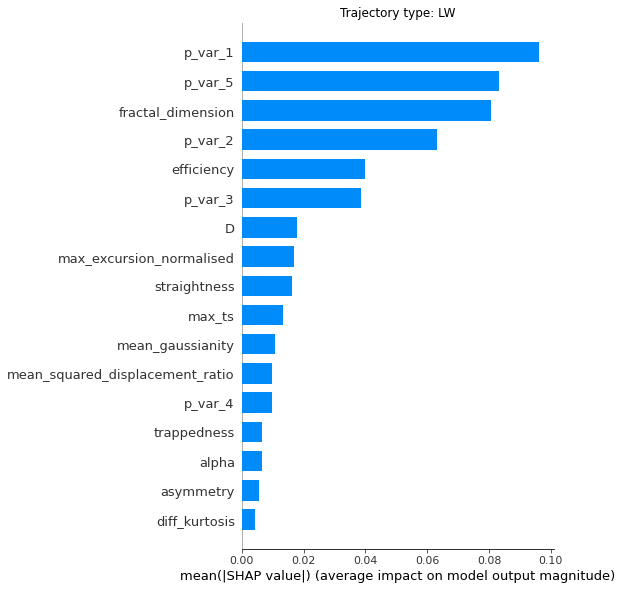

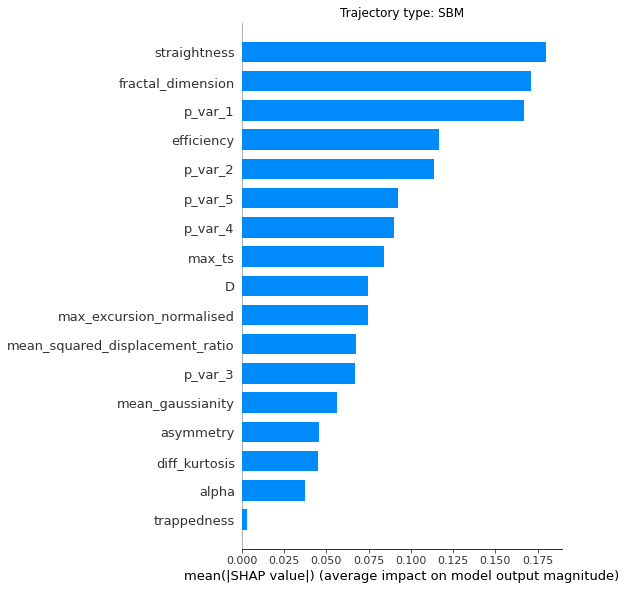

In [112]:
for i in range(5):
    plt.figure()
    shap.summary_plot(shap_coefs[i], x_test.columns, plot_type='bar', show=False)
    plt.title(f"Trajectory type: {CLASS_MAPPING[str(int(model.classes_[i]))]}")
    plt.tight_layout()
    plt.savefig(os.path.join('Explanation', 'SHAP', f'{CLASS_MAPPING[str(int(model.classes_[i]))]}.pdf'), dpi=400)
    plt.show()